## Implementation of the A2C - Agent

In [1]:
# install all needed modules with provided requirements file

import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_a2c.txt

  Using cached torch-1.7.1-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
  Using cached pandas-0.20.3.tar.gz (10.4 MB)
  ERROR: Command errored out with exit status 1:
   command: /home/phillip/Desktop/DataSience/venv-advml-project/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-eytdmu9o/pandas/setup.py'"'"'; __file__='"'"'/tmp/pip-install-eytdmu9o/pandas/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-6axd17q2
       cwd: /tmp/pip-install-eytdmu9o/pandas/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for pandas
  Running set

    copying pandas/core/util/__init__.py -> build/lib.linux-x86_64-3.8/pandas/core/util
    copying pandas/core/util/hashing.py -> build/lib.linux-x86_64-3.8/pandas/core/util
    creating build/lib.linux-x86_64-3.8/pandas/computation
    copying pandas/computation/__init__.py -> build/lib.linux-x86_64-3.8/pandas/computation
    copying pandas/computation/expressions.py -> build/lib.linux-x86_64-3.8/pandas/computation
    creating build/lib.linux-x86_64-3.8/pandas/errors
    copying pandas/errors/__init__.py -> build/lib.linux-x86_64-3.8/pandas/errors
    creating build/lib.linux-x86_64-3.8/pandas/formats
    copying pandas/formats/__init__.py -> build/lib.linux-x86_64-3.8/pandas/formats
    copying pandas/formats/style.py -> build/lib.linux-x86_64-3.8/pandas/formats
    creating build/lib.linux-x86_64-3.8/pandas/io
    copying pandas/io/stata.py -> build/lib.linux-x86_64-3.8/pandas/io
    copying pandas/io/pytables.py -> build/lib.linux-x86_64-3.8/pandas/io
    copying pandas/io/feathe

ERROR: Command errored out with exit status 1: /home/phillip/Desktop/DataSience/venv-advml-project/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-eytdmu9o/pandas/setup.py'"'"'; __file__='"'"'/tmp/pip-install-eytdmu9o/pandas/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-3f6t_uq7/install-record.txt --single-version-externally-managed --compile --install-headers /home/phillip/Desktop/DataSience/venv-advml-project/include/site/python3.8/pandas Check the logs for full command output.


In [23]:
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

First a network is created with layers for both the critic and the actor part:

In [24]:
class Model(nn.Module):
    def __init__(self, env):
        super(Model, self).__init__()

        self.env = env    

        hidden_size = 128
        self.num_actions = env.action_space.n
        self.num_inputs = env.observation_space.shape[0]

        self.critic_linear1 = nn.Linear(self.num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(self.num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, self.num_actions)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

Then the agent and it's train method get implemented:

In [25]:
class A2CAgent:

    def __init__(self, env, max_episodes, num_steps, gamma, learning_rate):

        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

        self.max_episodes = max_episodes
        self.num_steps = num_steps

        self.learning_rate = learning_rate
        self.gamma = gamma

        self.model = Model(env=env)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def train(self, shouldPrint, printStep):

        print("Start training...")
        
        num_outputs = env.action_space.n
        all_rewards = []
        entropy_term = 0

        for episode in range(self.max_episodes):
            log_probs = []
            values = []
            episode_rewards = []

            state = env.reset()
            for step in range(self.num_steps):
                value, policy_dist = self.model.forward(state)
                value = value.detach().numpy()[0, 0]
                dist = policy_dist.detach().numpy()

                action = np.random.choice(num_outputs, p=np.squeeze(dist))
                log_prob = torch.log(policy_dist.squeeze(0)[action])
                entropy = -np.sum(np.mean(dist) * np.log(dist))
                new_state, reward, done, _ = env.step(action)

                episode_rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                entropy_term += entropy
                state = new_state

                if done or step == self.num_steps - 1:
                    Qval, _ = self.model.forward(new_state)
                    Qval = Qval.detach().numpy()[0, 0]
                    all_rewards.append(np.sum(episode_rewards))

                    if shouldPrint and episode % printStep == 0:
                            print("Episode %03d  -  reward: %d" % (episode, np.sum(episode_rewards)))
                    break

            # compute Q values
            Qvals = np.zeros_like(values)
            for t in reversed(range(len(episode_rewards))):
                Qval = episode_rewards[t] + gamma * Qval
                Qvals[t] = Qval

            # update actor critic
            values = torch.FloatTensor(values)
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs)

            advantage = Qvals - values
            actor_loss = (-log_probs * advantage).mean()
            critic_loss = 0.5 * advantage.pow(2).mean()
            ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

            self.optimizer.zero_grad()
            ac_loss.backward()
            self.optimizer.step()

        print("Training finished...") 
        
        return all_rewards

Here is the main part of the notebook. The parameters for the agent get specified, the environment and the agent get initialized and the training starts.

In [30]:
# create environment
env = gym.make('Acrobot-v1')
env.reset()

# parameters
episodes = 5000
steps = 500
gamma = 0.99
lr = 0.0001

# create and train agent
agent = A2CAgent(env, episodes, steps, gamma, lr)
rewards = agent.train(False, 10)

Start training...
Training finished...


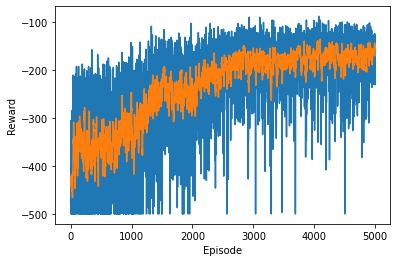

In [31]:
# Plot results
rewards_smoothed = pd.Series.rolling(pd.Series(rewards), 10).mean()
rewards_smoothed = [elem for elem in rewards_smoothed]
plt.plot(rewards)
plt.plot(rewards_smoothed)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()